In [1]:
import os
os.chdir("..")

In [2]:
ls

 驱动器 E 中的卷是 新加卷
 卷的序列号是 649B-E779

 E:\python\Learn\DL 的目录

2020/05/21  20:46    <DIR>          .
2020/05/21  20:46    <DIR>          ..
2020/05/16  16:21                40 .gitignore
2020/05/16  17:07    <DIR>          logic_regress
2020/05/23  00:26    <DIR>          more_layer
2020/05/16  17:03    <DIR>          one_layer
2020/05/12  10:29                42 README.md
               2 个文件             82 字节
               5 个目录 10,970,521,600 可用字节


In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from more_layer import testCase
from more_layer.dnn_utils import sigmoid,sigmoid_backward,relu,relu_backward
from logic_regress.data_1_2 import lr_utils

# n表示网络层，l为该层是哪一层，m为样本个数

In [4]:
np.random.seed(1)

## 初始化参数

In [5]:
def initialize_params(layer_dims):
#     构建单层参数
#     """
#     参数：
#         n - 当前隐层的神经元个数
#         n0 - 上一层隐层的神经元个数
#         在第一层中，将输入层的特征数表示为n0，而在最后一层中将输出类别作为当前层的神经元个数
        
#     返回：
#         w - 权重矩阵
#         b - 偏执量矩阵
    
#     """
#     w=np.random.randn(n,n0)
#     b=np.zeros(n,1)
    
#     return w,b

#  统一初始化
#  为了方便将所有神经层的参数都进行一层性初始化，并通过字典保存
    """
    参数：
        layer_dims - 列表类型，下标：每层的编号，元素：该层的神经元个数

    返回：
        params - 字典类型，key：每一层w/b的名称，value：对应w/b的初始化矩阵

    """
    np.random.seed(3)
    params = {}
    # 遍历神经网络的每一层，0层为输入层所以不需要初始化的
    for i in range(1,len(layer_dims)):
        
        params["w"+str(i)]=np.random.randn(layer_dims[i],layer_dims[i-1])/np.sqrt(layer_dims[i-1]) # *0.01 都是为了参数足够小1
        params["b"+str(i)]=np.zeros((layer_dims[i],1))

        assert(params["w"+str(i)].shape==(layer_dims[i],layer_dims[i-1]))
        assert(params["b"+str(i)].shape==(layer_dims[i],1))
    return params    


In [6]:
print("==============测试initialize_params==============")
layers_dims = [5,4,3]
parameters = initialize_params(layers_dims)
print("W1 = " + str(parameters["w1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["w2"]))
print("b2 = " + str(parameters["b2"]))

==============测试initialize_params==============
W1 = [[ 0.79989897  0.19521314  0.04315498 -0.83337927 -0.12405178]
 [-0.15865304 -0.03700312 -0.28040323 -0.01959608 -0.21341839]
 [-0.58757818  0.39561516  0.39413741  0.76454432  0.02237573]
 [-0.18097724 -0.24389238 -0.69160568  0.43932807 -0.49241241]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.59252326 -0.10282495  0.74307418  0.11835813]
 [-0.51189257 -0.3564966   0.31262248 -0.08025668]
 [-0.38441818 -0.11501536  0.37252813  0.98805539]]
b2 = [[0.]
 [0.]
 [0.]]


## 前向传递 

In [7]:
# 线性计算
def linear_forward(A_pre,w,b):
    """
    参数：
        A_pre - 前一层传入的数据，如第一层接收到0层传入的特征x矩阵包括样本数
        w - 该层初始化的参数
        b - 该层初始化的偏执
    
    返回：
        z - 通过线性组合生成的z矩阵，作为激活函数的输入
        cache - 元组类型，储存A,w,b，方便反向传递时调用.其中 A（前一层网络的输出，维度为[n^l-1,m]）
        w为该层网络初始化的权重维度为[n^l,n^l-1],b当前网络的偏执维度为[n^l,1]
    
    """
    
    z = np.dot(w, A_pre) + b
    
    assert(z.shape==(w.shape[0],A_pre.shape[1]))
    cache = (A_pre,w,b)
    return z, cache


In [8]:
print("==============测试linear_forward==============")
A_pre, w, b = testCase.linear_forward_test_case()
z,cache = linear_forward(A_pre,w,b)
print("Z = " + str(z))
print(cache)


==============测试linear_forward==============
Z = [[ 3.26295337 -1.23429987]]
(array([[ 1.62434536, -0.61175641],
       [-0.52817175, -1.07296862],
       [ 0.86540763, -2.3015387 ]]), array([[ 1.74481176, -0.7612069 ,  0.3190391 ]]), array([[-0.24937038]]))


In [9]:
# 激活函数
def linear_activate_forward(A_pre,w,b,activation_function):
    """
    参数：
        A_pre - 前一层传入的数据，如第一层接收到0层传入的特征x矩阵
        w - 该层初始化的参数
        b - 该层初始化的偏执
        activation_function - 所要使用的激活函数
    
    返回：
        gA - 激活后的A矩阵
        cache - 存储的是linear和activation的cache，其中linear与之前一致，activation：z（输入激活函数的矩阵维度为[n^l,m]）
    """
    z,linear_cache=linear_forward(A_pre,w,b)
    
    if activation_function== "sigmoid":
        gA,activation_cache=sigmoid(z)
    elif activation_function=="relu":
        gA,activation_cache=relu(z)
    
    assert(gA.shape==z.shape)
    cache=(linear_cache,activation_cache)
    
    return gA,cache




In [10]:
print("==============测试linear_activation_forward==============")
A_pre, w, b = testCase.linear_activation_forward_test_case()

gA, cache = linear_activate_forward(A_pre, w, b, activation_function = "sigmoid")
print("sigmoid，A = " + str(gA))

gA, cache = linear_activate_forward(A_pre,w, b, activation_function = "relu")
print("reLU，A = " + str(gA))


==============测试linear_activation_forward==============
sigmoid，A = [[0.96890023 0.11013289]]
reLU，A = [[3.43896131 0.        ]]


In [11]:
# 层间前向传递
def layer_forward_transfer(x,params):
    """
        参数：
            x - 为输入层的矩阵，是n^0层的属性
            params - 为初始化的各层参数的集合

        返回：
            Al - 最后的激活值
            caches - 包括：每一层的linear和activate的cache其中，activate中属于relu激活的cache有l-1个且不包含输入层，sigmod激活有一个

    """
    A = x
    caches=[]
    # 这里的len比layer_dims的长度少一个，因为n^0层没有参数
    l = len(params) // 2
    # 第一层到倒数第二层的relu激活     
    for i in range(1,l):
        A_pre = A
        A, cache = linear_activate_forward(A_pre,params["w" + str(i)],params["b"+str(i)],"relu")
        caches.append(cache)
    # 最后一层的sigmoid函数激活     
    Al, cache = linear_activate_forward(A, params["w"+str(l)], params["b"+str(l)],"sigmoid")
    caches.append(cache)
    # 针对二分类而不是多分类    
    assert(Al.shape == (1,x.shape[1]))
    
    return Al, caches

In [12]:
#测试layer_forward_transfer
print("==============测试layer_forward_transfer==============")
X,parameters = testCase.L_model_forward_test_case()
Al,caches = layer_forward_transfer(X,parameters)
print("AL = " + str(Al))
print("caches 的长度为 = " + str(len(caches)))

==============测试layer_forward_transfer==============
AL = [[0.17007265 0.2524272 ]]
caches 的长度为 = 2


## 计算成本 

In [13]:
# ^y= -[y*log(Al)+(1-y)log(1-Al)]
def compute_cost(Al,y):
    """
        参数：
            Al - 为最终sigmod计算后的激活值
            y - 为真实值的标签
        
        返回：
            cost - 对数似然损失值
    """
    
    # cost=-(np.multiply(np.log(Al), y) + np.multiply(np.log(1-Al)), (1-y)) / y.shape[1]    
    cost = y * np.log(Al) + (1-y) * (np.log(1-Al))
    cost = -(1/y.shape[1]) * np.sum(cost)

    assert(cost.shape == ())
    
    return cost   
    

In [14]:
#  测试compute_cost
print("==============测试compute_cost==============")
y,Al = testCase.compute_cost_test_case()
cost = compute_cost(Al, y)
print("损失值为：", cost)

==============测试compute_cost==============
损失值为： 0.41493159961539694


## 反向传播

In [15]:
def linear_backward(cache, dz):
    """
        参数：
            cache - 之前在linear_forward中保存的A_pre, w, b
            dz - 当前层中对z的求导也就是dl/dz
        
        返回：
            dw - 该层对权重（w）要更新的梯度
            db - 该层对偏执（b）要更新的梯度
            dA_pre - 前一层需要用到的w*dz，在前一层更新dz时会用到
    
    """
    
    A_pre, w, b = cache
    
    m = dz.shape[1]
    #  cache[i][0][0]为A_pre
    dw = np.dot(dz, A_pre.T) / m
    db = np.sum(dz, axis = 1, keepdims = True) / m
    dA_pre = np.dot(w.T, dz)

    assert(dw.shape == w.shape)
    assert(db.shape == b.shape)
    assert(dA_pre.shape == (w.shape[1], dz.shape[1]))
    
    return dw, db, dA_pre

In [16]:
# 测试liner_backward
print("==============测试liner_backward==============")
dz, cache = testCase.linear_backward_test_case()
dw, db, dA_pre = linear_backward(cache, dz)
print("dw: ", dw)
print("db: ", db)
print("dA_pre", dA_pre)

==============测试liner_backward==============
dw:  [[-0.10076895  1.40685096  1.64992505]]
db:  [[0.50629448]]
dA_pre [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]


In [17]:
def linear_activate_backward(dA, cache, activation_name):
    """
        参数：
            dA - 等于dA_pre，由之前的网络层传递过来，计算dz使用
            cache - 包含linear_cache和activation_cache
            activation_name - 激活函数的名称，用于对应导函数
            
        返回：
            dw - 该层对权重（w）要更新的梯度
            db - 该层对偏执（b）要更新的梯度
            dA_pre - 前一层需要用到的w*dz，在前一层更新dz时会用到
    
    """
    
    linear_cache, activation_cache = cache

    if activation_name == "sigmoid":
        dz = sigmoid_backward(dA, activation_cache)
        dw, db, dA_pre = linear_backward(linear_cache, dz)
    elif activation_name == "relu":
        # dA = w*dz dz = dA * g'         
        dz = relu_backward(dA, activation_cache)
        dw, db, dA_pre = linear_backward(linear_cache, dz)

    return dA_pre, dw, db

In [18]:
# 测试activat_backforward
print("==============测试activat_backforward==============")

dA, cache = testCase.linear_activation_backward_test_case()

dA_pre, dw, db = linear_activate_backward(dA, cache, "sigmoid")
print("sigmoid:")
print("dA_pre: ", dA_pre)
print("dw: ", dw)
print("db: ", db)

dA_pre, dw, db = linear_activate_backward(dA, cache, "relu")
print("relu:")
print("dA_pre: ", dA_pre)
print("dw: ", dw)
print("db: ", db)

==============测试activat_backforward==============
sigmoid:
dA_pre:  [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dw:  [[ 0.10266786  0.09778551 -0.01968084]]
db:  [[-0.05729622]]
relu:
dA_pre:  [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dw:  [[ 0.44513824  0.37371418 -0.10478989]]
db:  [[-0.20837892]]


In [68]:
# 层间后向传递
def layer_backward_transfer(y, Al, caches):
    """
        参数：
            y - 标签
            Al - 最后一次激活后计算的值
            caches - 在正向传播时记录的各个层的cache，包括linear和activation的cache
        
        返回：
            grads - 字典类型：
                    key：dw+层数 - value：每一层计算的权重梯度
                    key：db+层数 - value：每一层计算偏执梯度
    
    """
    
    dA = (-y/Al) + ((1-y) / (1-Al))
    l = len(caches)
    
    grads = {}
    dA, dw, db = linear_activate_backward(dA, caches[-1], "sigmoid")
    grads["dw" + str(l)] = dw
    grads["db" + str(l)] = db
    for i in range(l-2, -1, -1):
        # 等号前的dA为当前层的dA，也是下次迭代时所需的上一层的dA，等号后的dA则为该层的上一层的dA         
        dA, dw, db = linear_activate_backward(dA, caches[i], "relu")
        grads["dw" + str(i+1)] = dw
        grads["db" + str(i+1)] = db
    
    assert(Al.shape == y.shape)
    
    return grads
    

In [20]:
#测试layer_backward_transfer
print("==============测试layer_backward_transfer==============")
AL, Y_assess, caches = testCase.L_model_backward_test_case()
grads = layer_backward_transfer(Y_assess, AL, caches)
print ("dW1 = "+ str(grads["dw1"]))
print ("db1 = "+ str(grads["db1"]))


==============测试layer_backward_transfer==============
dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]


## 更新参数

In [21]:
def update_params(grads, params, lr):
    """
        参数：
            grads - 字典类型：
                    key：dw+层数 - value：每一层计算的权重梯度
                    key：db+层数 - value：每一层计算偏执梯度
            params - 字典类型，key：每一层w/b的名称，value：对应w/b的初始化矩阵
             lr - 学习率
        
        返回：
            params - 跟新后的各个参数
    """
    
    for name in params:
        params[name] = params[name] - lr * grads["d" + name]
    
    return params

In [22]:
#测试update_params
print("==============测试update_params==============")
parameters, grads = testCase.update_parameters_test_case()
parameters = update_params(grads, parameters, 0.1)
 
print ("W1 = "+ str(parameters["w1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["w2"]))
print ("b2 = "+ str(parameters["b2"]))

==============测试update_params==============
W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


## 预测

In [97]:
def predict(x=None, y=None, o_Al=None, params=None):
    """
        参数：
            x - 各个样本的特征值
            y - 对应样本的标签
            o_Al - 最后一次激活函数返回的值，用于在训练的时候进行loss和acc的计算
            params - 参数，包括各个网络的权重和偏置
        
        返回：
            cost - 成本，损失或者误差
            acc - 当前参数下的准确率
    
    """
    
    if isinstance(x, np.ndarray):
    # 前向传播     
        Al, cache = layer_forward_transfer(x, params)
    elif isinstance(o_Al, np.ndarray):
        Al = o_Al
    cost = compute_cost(Al, y)
    pre_y = np.round(Al)
    acc = np.mean(np.equal(pre_y,y))
    return cost, acc, pre_y

## 搭建2层网络

In [99]:
def model(x, y, layer_dims, lr, iteration=3000, print_cost=False, plt_cost=False):
    """
        参数：
            x - 各个样本的参数值
            y - 对应样本的标签
            layer_dims - 列表类型，下标：每层的编号，元素：该层的神经元个数即网络结构
            lr - 学习率
            iteration - 迭代次数
            print_cost - 是否打印成本
            plt_cost - 是否打印损失曲线
        
        返回：
            params - 最终训练完成后的权重
        
        """
    
    np.random.seed(1)
    costs = []
    # 初始化参数
    params = initialize_params(layer_dims)
    # 迭代训练    
    for i in range(iteration):
        # 前向传播                 
        Al, caches = layer_forward_transfer(x,params)
        # 计算损失和准确率
        cost, acc, pre_y = predict(o_Al=Al, y=y, params=params)
        # 反向传播
        grads = layer_backward_transfer(y=y, Al=Al, caches=caches)
        # 更新参数
        params = update_params(grads, params, lr=lr)
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("第%i次迭代的loss: %f, 准确率为: %f"%(i, cost, acc))
    if plt_cost:
        plt.figure(figsize=(20, 20))
        plt.plot(np.squeeze(costs))
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.title("Loss_Learn rate: %f" + str(lr))
        plt.show()
    return params

## 加载数据

In [37]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

## 两层网络

第0次迭代的loss: 0.672879, 准确率为: 0.612440
第100次迭代的loss: 0.528575, 准确率为: 0.684211
第200次迭代的loss: 0.458180, 准确率为: 0.732057
第300次迭代的loss: 0.387653, 准确率为: 0.794258
第400次迭代的loss: 0.351647, 准确率为: 0.799043
第500次迭代的loss: 0.255323, 准确率为: 0.928230
第600次迭代的loss: 0.236037, 准确率为: 0.942584
第700次迭代的loss: 0.337667, 准确率为: 0.846890
第800次迭代的loss: 0.154820, 准确率为: 0.966507
第900次迭代的loss: 0.141659, 准确率为: 0.966507
第1000次迭代的loss: 0.107018, 准确率为: 0.980861
第1100次迭代的loss: 0.089376, 准确率为: 0.990431
第1200次迭代的loss: 0.077089, 准确率为: 0.995215
第1300次迭代的loss: 0.065752, 准确率为: 0.995215
第1400次迭代的loss: 0.054195, 准确率为: 0.995215
第1500次迭代的loss: 0.046712, 准确率为: 1.000000
第1600次迭代的loss: 0.041145, 准确率为: 1.000000
第1700次迭代的loss: 0.036671, 准确率为: 1.000000
第1800次迭代的loss: 0.032914, 准确率为: 1.000000
第1900次迭代的loss: 0.029734, 准确率为: 1.000000
第2000次迭代的loss: 0.027067, 准确率为: 1.000000
第2100次迭代的loss: 0.024722, 准确率为: 1.000000
第2200次迭代的loss: 0.022701, 准确率为: 1.000000
第2300次迭代的loss: 0.020914, 准确率为: 1.000000
第2400次迭代的loss: 0.019359, 准确率为: 1.000000


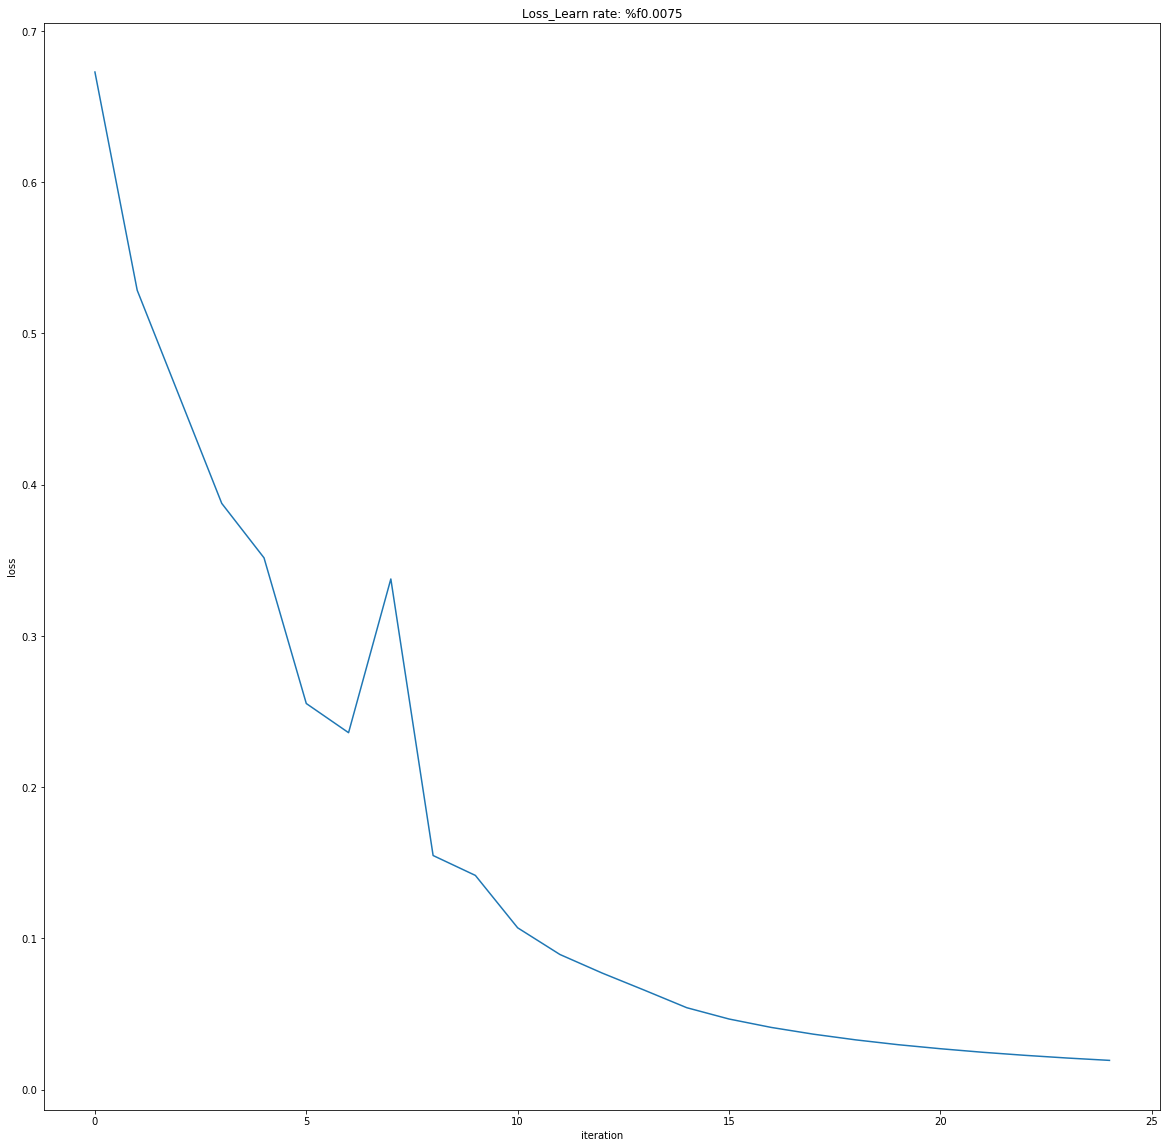

In [100]:
layer_dims = [train_x.shape[0], 7, train_y.shape[0]]
new_params = model(x=train_x, y=train_y, lr=0.0075, layer_dims=layer_dims, iteration=2500, print_cost=True, plt_cost=True) 

In [101]:
cost, acc, pred_y = predict(x=test_x, y=test_y, o_Al=None, params=new_params)
print("损失：", cost)
print("准确率：", acc)

损失： 0.9409009224952715
准确率： 0.76


## 五层神经网络

第0次迭代的loss: 0.715732, 准确率为: 0.344498
第100次迭代的loss: 0.674738, 准确率为: 0.665072
第200次迭代的loss: 0.660337, 准确率为: 0.665072
第300次迭代的loss: 0.646289, 准确率为: 0.684211
第400次迭代的loss: 0.629813, 准确率为: 0.688995
第500次迭代的loss: 0.606006, 准确率为: 0.732057
第600次迭代的loss: 0.569004, 准确率为: 0.803828
第700次迭代的loss: 0.519797, 准确率为: 0.866029
第800次迭代的loss: 0.464157, 准确率为: 0.913876
第900次迭代的loss: 0.408420, 准确率为: 0.952153
第1000次迭代的loss: 0.373155, 准确率为: 0.952153
第1100次迭代的loss: 0.305724, 准确率为: 0.971292
第1200次迭代的loss: 0.268102, 准确率为: 0.980861
第1300次迭代的loss: 0.238725, 准确率为: 0.980861
第1400次迭代的loss: 0.206323, 准确率为: 0.990431
第1500次迭代的loss: 0.179439, 准确率为: 0.995215
第1600次迭代的loss: 0.157987, 准确率为: 0.995215
第1700次迭代的loss: 0.142404, 准确率为: 0.995215
第1800次迭代的loss: 0.128652, 准确率为: 0.995215
第1900次迭代的loss: 0.112443, 准确率为: 0.995215
第2000次迭代的loss: 0.085056, 准确率为: 0.995215
第2100次迭代的loss: 0.057584, 准确率为: 0.995215
第2200次迭代的loss: 0.044568, 准确率为: 0.995215
第2300次迭代的loss: 0.038083, 准确率为: 0.995215
第2400次迭代的loss: 0.034411, 准确率为: 0.995215


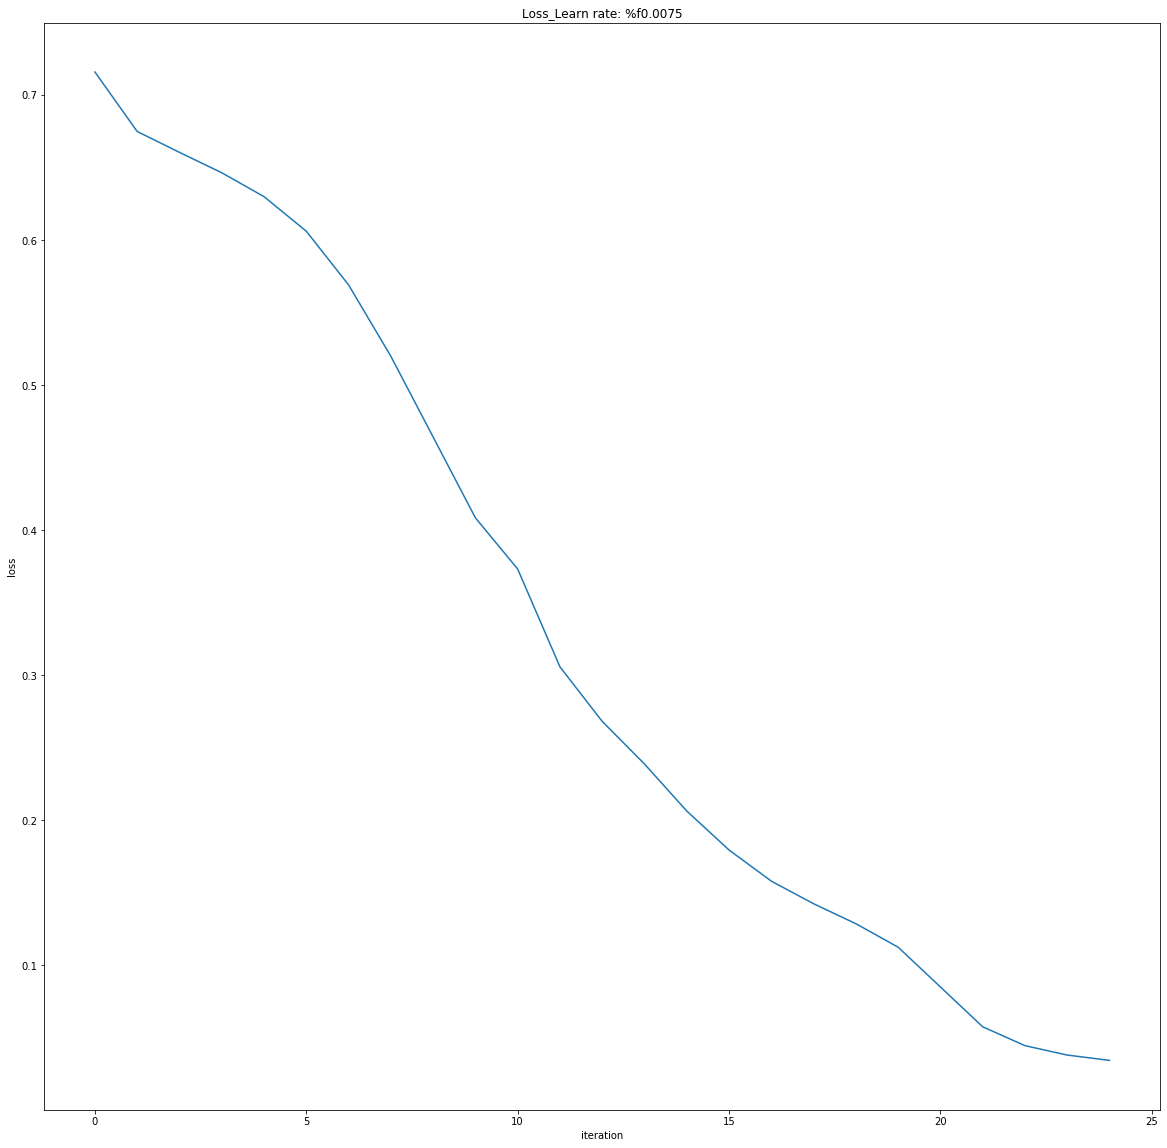

In [102]:
layer_dims = [train_x.shape[0], 20, 7, 5, train_y.shape[0]]
new_params = model(x=train_x, y=train_y, lr=0.0075, layer_dims=layer_dims, iteration=2500, print_cost=True, plt_cost=True) 

In [105]:
cost, acc, pred_y = predict(x=test_x, y=test_y, o_Al=None, params=new_params)
print("损失：", cost)
print("准确率：", acc)

损失： 0.752902813036192
准确率： 0.78


## 分析错误标记 

In [174]:
def analyze(classes, x, y, pred_y):
    mislabel = y + pred_y
    # 将value为1的位置下标生成一个array
    mislabel = np.asarray(np.where(mislabel == 1))
    plt.figure(figsize=(20, 20))
    # 这样会先每行按照列进行顺序排序，本来没个样本应该是每一列，但这样就按照行来进行样本分割了，一行为一个特征    
    #  x = x.reshape(-1, 64, 64, 3)
    for i in range(len(mislabel[1])):
        # 判断错误的图像的位置         
        num = mislabel[1][i]
        # 先确定每个样本         
        img = x[ : , num]
        plt.subplot(2, len(mislabel[1]), i + 1)
        # 从样本中再划分特征         
        plt.imshow(img.reshape(64, 64, 3), interpolation='nearest')
        plt.axis("off")
        plt.title("Prediction:" + classes[int(pred_y[0][num])].decode("utf-8") + "\n True_Class:" + classes[int(y[0][num])].decode("utf-8"))        

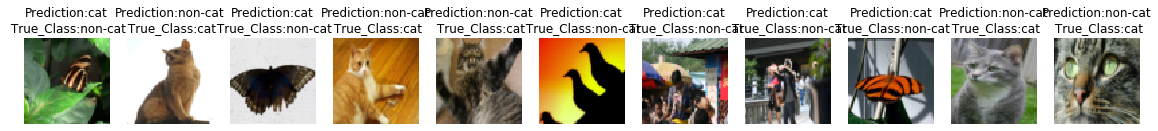

In [175]:
analyze(classes, test_x, test_y, pred_y)

模型会受到猫在图片中的位置和大小，以及对比色差的ying'xing